In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.functions import col, month, avg
from pyspark.sql import Row

In [0]:


# Define the schema for the DataFrame
schema = StructType([
    StructField("month", IntegerType()),
    StructField("avg_ele", DoubleType()),
    StructField("avg_winddir", DoubleType()),
    StructField("avg_sky", DoubleType()),
    StructField("avg_visdist", DoubleType()),
    StructField("avg_airtemp", DoubleType()),
    StructField("avg_dewpointtemp", DoubleType()),
    StructField("avg_atmpress", DoubleType()),
    StructField("Year", IntegerType())
])

# Read the CSV file with the specified schema
year_month_df = spark.read.format("csv") \
    .option("header", "true") \
    .schema(schema) \
    .load("dbfs:/FileStore/Shannon_all_year/merged_year.csv")




In [0]:
year_month_df.show()

+-----+-------+------------------+------------------+------------------+------------------+------------------+------------------+----+
|month|avg_ele|       avg_winddir|           avg_sky|       avg_visdist|       avg_airtemp|  avg_dewpointtemp|      avg_atmpress|Year|
+-----+-------+------------------+------------------+------------------+------------------+------------------+------------------+----+
|    1|   20.0|207.60547156227503| 10587.07199424046| 18360.76241900648|  7.31360691144708| 5.272714182865368| 5267.080057595452|1976|
|    2|   20.0| 215.1534090909091| 6033.500811688312| 19491.39366883117| 7.358035714285722| 5.042694805194806| 5177.837987013024|1976|
|    3|   20.0|232.57503607503608| 8002.277056277056|20170.344877344876| 9.264285714285704| 6.344660894660886| 5220.431240981297|1976|
|    4|   20.0|238.64269829503337|13875.328391401035|18756.706449221645| 8.877094143810227| 4.727131208302449| 5252.800222387012|1976|
|    5|   20.0|214.27138849929875| 16518.35624123422| 1

In [0]:


# Prepare the Data
assembler = VectorAssembler(inputCols=["Year", "month"], outputCol="features")
df = assembler.transform(year_month_df)

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Define the Linear Regression Model
lre = LinearRegression(featuresCol="features", labelCol="avg_airtemp")

# Train the Model
lre_model = lre.fit(train_data)

#  Evaluate the Model
predictions_lre = lre_model.transform(test_data)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="avg_airtemp", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_lre)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", rmse)

# Optionally, we can also print the coefficients and intercept of the model
print("Coefficients:", lre_model.coefficients)
print("Intercept:", lre_model.intercept)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="avg_airtemp", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions_lre)

# Print the R-squared value
print("R-squared (R2) Score:", r2)

Root Mean Squared Error (RMSE): 3.632771099237942
Coefficients: [0.01163421150311734,0.3443110158329165]
Intercept: -14.833510864911998
R-squared (R2) Score: -0.004775757409528847


In [0]:


# Prepare the Data
assembler = VectorAssembler(inputCols=["Year", "month"], outputCol="features")
df = assembler.transform(year_month_df)

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = df.randomSplit([0.6, 0.4], seed=123)

# Define Polynomial Expansion
poly_expansion = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=2)

# Define the Linear Regression Model
lr = LinearRegression(featuresCol="poly_features", labelCol="avg_airtemp")

#  Create a Pipeline
pipeline = Pipeline(stages=[poly_expansion, lr])

# Train the Model
lr_model = pipeline.fit(train_data)

# Evaluate the Model
predictions = lr_model.transform(test_data)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="avg_airtemp", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", rmse)

# Optionally, we can also print the coefficients and intercept of the model
print("Coefficients:", lr_model.stages[-1].coefficients)
print("Intercept:", lr_model.stages[-1].intercept)

# Calculate evaluation metrics
evaluator = RegressionEvaluator(labelCol="avg_airtemp", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

# Print the R-squared value
print("R-squared (R2) Score:", r2)


Root Mean Squared Error (RMSE): 1.8492451394607388
Coefficients: [4.542624864176402,-0.00112910476346337,8.630537113779177,-0.0021882357808659806,-0.30082914453281084]
Intercept: -4569.488552621854
R-squared (R2) Score: 0.7463385581251749


In [0]:
from pyspark.sql import Row

# Create a list of Row objects, each representing a month in 2024
months_2024 = [
    Row(Year=2024, month=1),
    Row(Year=2024, month=2),
    Row(Year=2024, month=3)
]

# Create a DataFrame from the list of Row objects
prediction_data = spark.createDataFrame(months_2024)

# Transform the prediction data using the assembler
prediction_data = assembler.transform(prediction_data)

# Transform the prediction data using the polynomial expansion and linear regression stages
prediction_result = lr_model.transform(prediction_data)

# Show the prediction result
prediction_result.select("Year", "month", "prediction").display()


Year,month,prediction
2024,1,3.221415730240551
2024,2,6.520476189947658
2024,3,9.217878360590475


In [0]:


unseen_df=spark.read.option("header", "true").csv("dbfs:/FileStore/Shannon_all_year/2024.csv")

# Average the airtemp, visdist, winddir, sky, atmpress over each month of the unseen_df DataFrame
average_df = unseen_df.groupBy(month("date").alias("month")).agg(
    avg(col("airtemp")).alias("avg_airtemp"),
    avg(col("visdist")).alias("avg_visdist"),
    avg(col("winddir")).alias("avg_winddir"),
    avg(col("sky")).alias("avg_sky"),
    avg(col("atmpress")).alias("avg_atmpress")
)



ordered_df = average_df.orderBy("month")
ordered_df.display()


month,avg_airtemp,avg_visdist,avg_winddir,avg_sky,avg_atmpress
1,5.166651705565528,12960.145421903053,262.1584380610413,23949.94658886894,7007.867594255113
2,8.218768046198273,11711.609720885466,213.52454282964388,10962.844562078923,6996.389509143572
3,8.353887113951,12455.732161874334,204.4989350372737,12321.160276890309,7001.362406815917
4,10.440322580645168,13043.381231671554,203.83724340175954,7220.491202346041,7004.520087976533


Predicting the avg_temp till 2060

In [0]:


# Create a list of Row objects for each month from 2024 to 2060
months_2024_to_2061 = [Row(Year=year, month=month) for year in range(2024, 2061) for month in range(1, 13)]

# Create a DataFrame from the list of Row objects
prediction_data = spark.createDataFrame(months_2024_to_2061)

# Transform the prediction data using the assembler
prediction_data = assembler.transform(prediction_data)

# Transform the prediction data using the polynomial expansion and linear regression stages
prediction_result = lr_model.transform(prediction_data)

# Show the prediction result
prediction_result.select("Year", "month", "prediction").display()

# Convert selected table to a DataFrame
prediction__future_df = prediction_result.select("Year", "month", "prediction").toDF("Year", "month", "prediction")


Year,month,prediction
2024,1,3.221415730240551
2024,2,6.520476189947658
2024,3,9.217878360590475
2024,4,11.313622242167185
2024,5,12.807707834678695
2024,6,13.700135138124097
2024,7,13.9909041525043
2024,8,13.680014877817484
2024,9,12.76746731406729
2024,10,11.253261461250077


Plotting the Average temperature of each month for 2024

    month  prediction
0       1    3.221416
1       2    6.520476
2       3    9.217878
3       4   11.313622
4       5   12.807708
5       6   13.700135
6       7   13.990904
7       8   13.680015
8       9   12.767467
9      10   11.253261
10     11    9.137397
11     12    6.419875


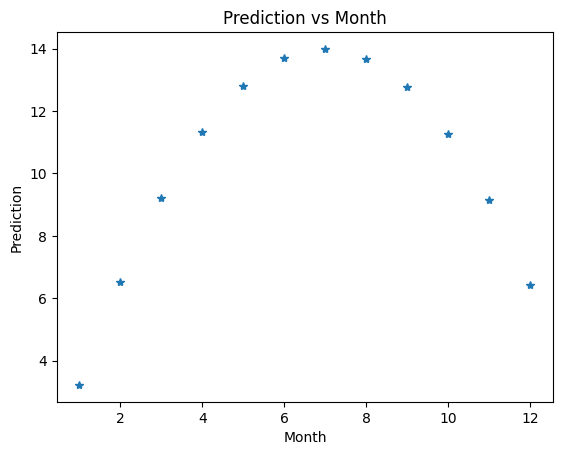

In [0]:


# Get the first 24 rows of prediction__future_df
first_24_rows = prediction__future_df.limit(12)



# Convert Spark DataFrame to Pandas DataFrame
prediction_pd = first_24_rows.select('month', 'prediction').toPandas()
print(prediction_pd)

# Plot month and prediction columns
plt.plot(prediction_pd['month'], prediction_pd['prediction'], "*")
plt.xlabel('Month')
plt.ylabel('Prediction')
plt.title('Prediction vs Month')



plt.show()

Plotting till 2060

In [0]:
# Group the prediction__future_df by 'Year' and calculate the average temperature for each year
yearly_avg_temperatures = prediction__future_df.groupBy("Year").avg("prediction")

# Rename the columns
yearly_avg_temperatures = yearly_avg_temperatures.withColumnRenamed("Year", "Year")
yearly_avg_temperatures = yearly_avg_temperatures.withColumnRenamed("avg(prediction)", "Average Temperature")

# Show the yearly average temperatures
yearly_avg_temperatures.orderBy("Year").display()

Year,Average Temperature
2024,10.335846292431143
2025,10.292502436768169
2026,10.24690037157825
2027,10.199040096864033
2028,10.148921612620674
2029,10.096544918850364
2030,10.041910015552958
2031,9.9850169027283
2032,9.92586558037677
2033,9.864456048500793


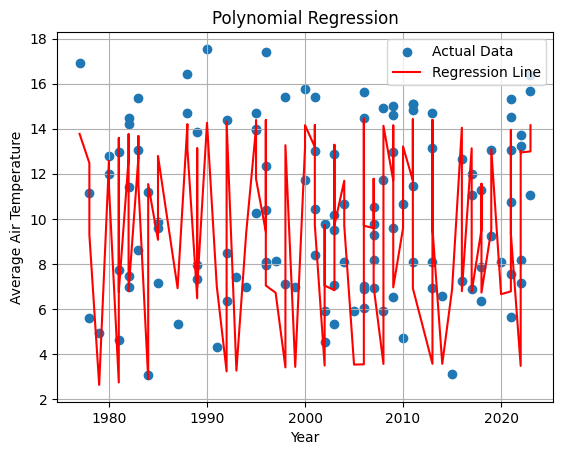

In [0]:



# Convert Spark DataFrame to Pandas DataFrame
predictions_pd = predictions.select('Year', 'month', 'avg_airtemp', 'prediction').toPandas()

# Sort the data by 'Year' and 'month' for visualization
predictions_pd = predictions_pd.sort_values(by=['Year', 'month'])

# Plot the actual data points
plt.scatter(predictions_pd['Year'], predictions_pd['avg_airtemp'], label='Actual Data')

# Plot the predicted values (regression line)
plt.plot(predictions_pd['Year'], predictions_pd['prediction'], color='red', label='Regression Line')

plt.xlabel('Year')
plt.ylabel('Average Air Temperature')
plt.title('Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()


Trying to find the average temperature with day as an additional feature

------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Define the schema for the DataFrame
schema_day_test = StructType([
    StructField("year", IntegerType()),
    StructField("month", IntegerType()),
    StructField("day", IntegerType()),
    StructField("ele", DoubleType()),
    StructField("winddir", DoubleType()),
    StructField("sky", DoubleType()),
    StructField("visdist", DoubleType()),
    StructField("airtemp", DoubleType()),
    StructField("dewpointtemp", DoubleType()),
    StructField("atmpress", DoubleType())
])

# Read the CSV file with the specified schema
year_month__day_df_test = spark.read.format("csv") \
    .option("header", "true") \
    .schema(schema_day_test) \
    .load("dbfs:/FileStore/Shannon_all_year/avgPerDay.csv")
    # Filter out data for the year 2024 and 2023
year_month__day_df_test = year_month__day_df_test.filter((col("year") != 2024)& (col("year") != 2023))
year_month__day_df_test.show(10)

+----+-----+---+----+------------------+------------------+------------------+------------------+------------------+------------------+
|year|month|day| ele|           winddir|               sky|           visdist|           airtemp|      dewpointtemp|          atmpress|
+----+-----+---+----+------------------+------------------+------------------+------------------+------------------+------------------+
|1976|    1|  1|14.0| 212.6086956521739| 760.4347826086956| 8921.739130434782|7.3478260869565215| 5.869565217391305| 1402.513043478261|
|1976|    1|  2|14.0| 273.2916666666667| 6412.458333333333| 9470.833333333334|               9.5| 7.416666666666667|1754.5166666666669|
|1976|    1|  3|14.0| 270.4166666666667| 8415.416666666666|12654.166666666666|              5.75|1.7916666666666667|1024.6208333333334|
|1976|    1|  4|14.0|             217.5|             320.0| 4416.666666666667| 8.916666666666666| 8.208333333333334|1019.4208333333332|
|1976|    1|  5|14.0|            236.25|2543.333

In [0]:


# Prepare the Data
assembler_day_test= VectorAssembler(inputCols=["year", "month","day"], outputCol="features")
df_day_test = assembler_day_test.transform(year_month__day_df_test)

# Split the data into training and testing sets (70% training, 30% testing)
train_data_day_test, test_data_day_test = df_day_test.randomSplit([0.9, 0.1], seed=123)

# Define Polynomial Expansion
poly_expansion_test = PolynomialExpansion(inputCol="features", outputCol="poly_features", degree=3)

# Define the Linear Regression Model
lr_day_test = LinearRegression(featuresCol="poly_features", labelCol="airtemp")

#  Create a Pipeline
pipeline_day_test = Pipeline(stages=[poly_expansion_test, lr_day_test])

# Train the Model
lr_model_day_test = pipeline_day_test.fit(train_data_day_test)

# Evaluate the Model
predictions_day_test = lr_model_day_test.transform(test_data_day_test)

# Calculate evaluation metrics
evaluator_day_test = RegressionEvaluator(labelCol="airtemp", predictionCol="prediction", metricName="rmse")
rmse_day_test= evaluator_day_test.evaluate(predictions_day_test)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", rmse_day_test)

# Optionally, we can also print the coefficients and intercept of the model
print("Coefficients:", lr_model_day_test.stages[-1].coefficients)
print("Intercept:", lr_model_day_test.stages[-1].intercept)

# Calculate evaluation metrics
evaluator_day_r2_test = RegressionEvaluator(labelCol="airtemp", predictionCol="prediction", metricName="r2")
r2_day_test = evaluator_day_r2_test.evaluate(predictions_day_test)

# Print the R-squared value
print("R-squared (R2) Score:", r2_day_test)


Root Mean Squared Error (RMSE): 2.647412946379283
Coefficients: [101.51935701500085,-0.04914355834594225,7.921215726242926e-06,330.7929389235333,-0.32753782179659624,8.113928676662474e-05,0.14007044079628633,0.00013221957541061595,-0.03412912898835112,128.31009046556014,-0.13128699114084244,3.35805482909189e-05,0.031288008991720774,-8.367555635388361e-06,-0.0020606484849527,0.15084952050223105,-7.736046660182215e-05,5.5688209902781614e-06,8.875109056509663e-05]
Intercept: -69829.98803304993
R-squared (R2) Score: 0.6312505986303845


In [0]:
# Function to generate Row objects for all days in a given month
def generate_month_days(year, month):
    num_days = calendar.monthrange(year, month)[1]
    return [Row(year=year, month=month, day=day) for day in range(1, num_days+1)]

# Create Row objects for all days in January, February, and March 2024
january_days = generate_month_days(2024, 1)
february_days = generate_month_days(2024, 2)
march_days = generate_month_days(2024, 3)

# Combine all days into a single list
all_days_2024 = january_days + february_days + march_days

In [0]:



# Create a DataFrame from the list of Row objects
prediction_data_day_test = spark.createDataFrame(all_days_2024)

# Transform the prediction data using the assembler
prediction_data_day_test = assembler_day_test.transform(prediction_data_day_test)

# Transform the prediction data using the polynomial expansion and linear regression stages
prediction_result_day_test = lr_model_day_test.transform(prediction_data_day_test)

# Show the prediction result
avg_perday_2024_predicted_df_test=prediction_result_day_test.select("year", "month", "day", "prediction").toDF("year", "month", "day","airtemp_prediction")

# Group by month and calculate the average airtemp_prediction
monthly_avg_airtemp_predicted_day_test = avg_perday_2024_predicted_df_test.groupBy("month").avg("airtemp_prediction")

# Order by month
monthly_avg_airtemp_predicted_day_test = monthly_avg_airtemp_predicted_day_test.orderBy("month")

#Show
monthly_avg_airtemp_predicted_day_test.display()


month,avg(airtemp_prediction)
1,5.399301052724402
2,6.7038974224149195
3,8.471937141422513


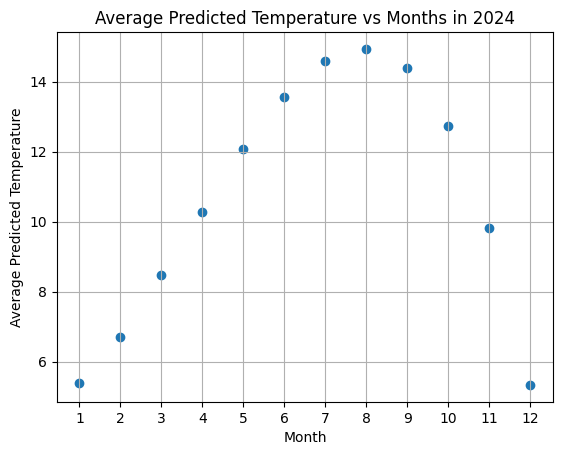

In [0]:
import matplotlib.pyplot as plt

# Generate Row objects for all days in January, February, and March 2024
january_days = generate_month_days(2024, 1)
february_days = generate_month_days(2024, 2)
march_days = generate_month_days(2024, 3)
april_days = generate_month_days(2024, 4)
may_days = generate_month_days(2024, 5)
june_days = generate_month_days(2024, 6)
july_days = generate_month_days(2024, 7)
august_days=generate_month_days(2024, 8)
september_days=generate_month_days(2024, 9)
october_days=generate_month_days(2024, 10)
november_days=generate_month_days(2024, 11)
december_days=generate_month_days(2024, 12)



# Combine all days into a single list
all_days_2024 = january_days + february_days + march_days+april_days+may_days+june_days+july_days+august_days+september_days+october_days+november_days+december_days

# Create a DataFrame from the list of Row objects
prediction_data_day_test = spark.createDataFrame(all_days_2024)

# Transform the prediction data using the assembler
prediction_data_day_test = assembler_day_test.transform(prediction_data_day_test)

# Transform the prediction data using the polynomial expansion and linear regression stages
prediction_result_day_test = lr_model_day_test.transform(prediction_data_day_test)

# Select necessary columns and rename prediction column
avg_perday_2024_predicted_df_test = prediction_result_day_test.select("year", "month", "day", "prediction") \
    .toDF("year", "month", "day", "airtemp_prediction")

# Group by month and calculate the average airtemp_prediction
monthly_avg_airtemp_predicted_day_test = avg_perday_2024_predicted_df_test.groupBy("month").avg("airtemp_prediction")

# Order by month
monthly_avg_airtemp_predicted_day_test = monthly_avg_airtemp_predicted_day_test.orderBy("month")

# Extract the months and temperatures for plotting
months = monthly_avg_airtemp_predicted_day_test.select("month").rdd.flatMap(lambda x: x).collect()
avg_temperatures = monthly_avg_airtemp_predicted_day_test.select("avg(airtemp_prediction)").rdd.flatMap(lambda x: x).collect()

# Plot the averaged temperature against the months
plt.scatter(months, avg_temperatures)
plt.xlabel("Month")
plt.ylabel("Average Predicted Temperature")
plt.title("Average Predicted Temperature vs Months in 2024")
plt.xticks(months)
plt.grid(True)
plt.show()
